# 2023/24 Season Data Prep and EDA

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math

In [45]:
# Import data
season_14 = pd.read_csv("../data/2014_season.csv")
season_15 = pd.read_csv("../data/2015_season.csv")
season_16 = pd.read_csv("../data/2016_season.csv")
season_17 = pd.read_csv("../data/2017_season.csv")
season_18 = pd.read_csv("../data/2018_season.csv")
season_19 = pd.read_csv("../data/2019_season.csv")
season_20 = pd.read_csv("../data/2020_season.csv")
season_21 = pd.read_csv("../data/2021_season.csv")
season_22 = pd.read_csv("../data/2022_season.csv")
season_23 = pd.read_csv("../data/2023_season.csv")
season_24 = pd.read_csv("../data/2024_season.csv")

## 1. Data Cleaning

In [46]:
# Remove Playoff fixtures
season_23.drop(season_23.tail(5).index, inplace = True)
season_24.drop(season_24.tail(1).index, inplace = True)

# Remove Bye Week
season_23.drop(season_23.index[8], inplace = True)
season_24.drop(season_24.index[8], inplace = True)

In [47]:
def tidy_columns(df, year=None):
    # Function to create win/lose binary
    def wl(row):
        if row['Unnamed: 5'] == 'W':
            val = 1     # Win
            return val
        elif row['Unnamed: 5'] == 'L':
            val = 0     # Lose
            return val
    df["win_lose"] = df.apply(wl, axis=1)


    def hw(row):
        if row['Unnamed: 9'] == '@':
            return 0    # Away
        else:
            return 1    # Home
    df["home_away"] = df.apply(hw, axis=1)


    # Drop unwanted columns
    df.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'OT', 'Unnamed: 9'], axis = 1, inplace=True)

    # Add year column
    df.insert(loc=3, column='year', value=year)

In [48]:
tidy_columns(season_14, year=2014)
tidy_columns(season_15, year=2015)
tidy_columns(season_16, year=2016)
tidy_columns(season_17, year=2017)
tidy_columns(season_18, year=2018)
tidy_columns(season_19, year=2019)
tidy_columns(season_20, year=2020)
tidy_columns(season_21, year=2021)
tidy_columns(season_22, year=2022)
tidy_columns(season_23, year=2023)
tidy_columns(season_24, year=2024)

**Dictionary**

*win_lose*

win = 1

lose = 0

----

*home_away*

home = 1

lose = 0

## 2. Dervied attributes

In [49]:
# Point Differential
def diffs(df):
    df["point_diff"] = df["score_tm"] - df["score_opp"]
    df["turnover_diff"] = df["defense_to"] - df["offense_to"]

diffs(season_14)
diffs(season_15)
diffs(season_16)
diffs(season_17)
diffs(season_18)
diffs(season_19)
diffs(season_20)
diffs(season_21)
diffs(season_22)
diffs(season_23)
diffs(season_24)

## 3. Exploratory Data Analysis - 2023 Season
### First half vs second half of season

In [28]:
season_23.columns

Index(['Week', 'Day', 'Date', 'year', 'sf_rec', 'opp_rec', 'Opp', 'score_tm',
       'score_opp', 'offense_1stD', 'offense_totYd', 'offense_passY',
       'offense_rushY', 'offense_to', 'defense_1stD', 'defense_totYd',
       'defence_passY', 'defense_rushY', 'defense_to', 'ep_offense',
       'ep_defense', 'ep_sp_Tms', 'win_lose', 'home_away', 'point_diff',
       'turnover_diff'],
      dtype='object')

In [29]:
season_23["Week"] = pd.to_numeric(season_23["Week"], downcast = "integer")

# Dictionary of metrics and calucations
metrics = {
    "points_scored_avg": ("score_tm", "mean"),
    "points_allowed_avg": ("score_opp", "mean"),
    "point_differential_avg": (["score_tm", "score_opp"], "diff"),
    "total_yards_avg": ("offense_totYd", "mean"),
    "yards_allowed_avg": ("defense_totYd", "mean"),
    "turnovers_lost_avg": ("offense_to", "mean"),
    "turnovers_gained_avg": ("defense_to", "mean")
}

# Empty list to collect rows
rows = []

for metric_name, (col, calc) in metrics.items():
    if calc == "mean":
        first_half = season_23.loc[season_23["Week"] <= 9, col].mean()
        second_half = season_23.loc[season_23["Week"] >= 10, col].mean()
    elif calc == "diff":
        first_half = (season_23.loc[season_23["Week"] <= 9, "score_tm"] - 
                    season_23.loc[season_23["Week"] <= 9, "score_opp"]).mean()
        second_half = (season_23.loc[season_23["Week"] >= 10, "score_tm"] - 
                    season_23.loc[season_23["Week"] >= 10, "score_opp"]).mean()

    rows.append({
        "metric": metric_name,
        "weeks_1-9": first_half,
        "weeks_10-18": second_half
    })

# Build final DataFrame
season_23_halves = pd.DataFrame(rows)

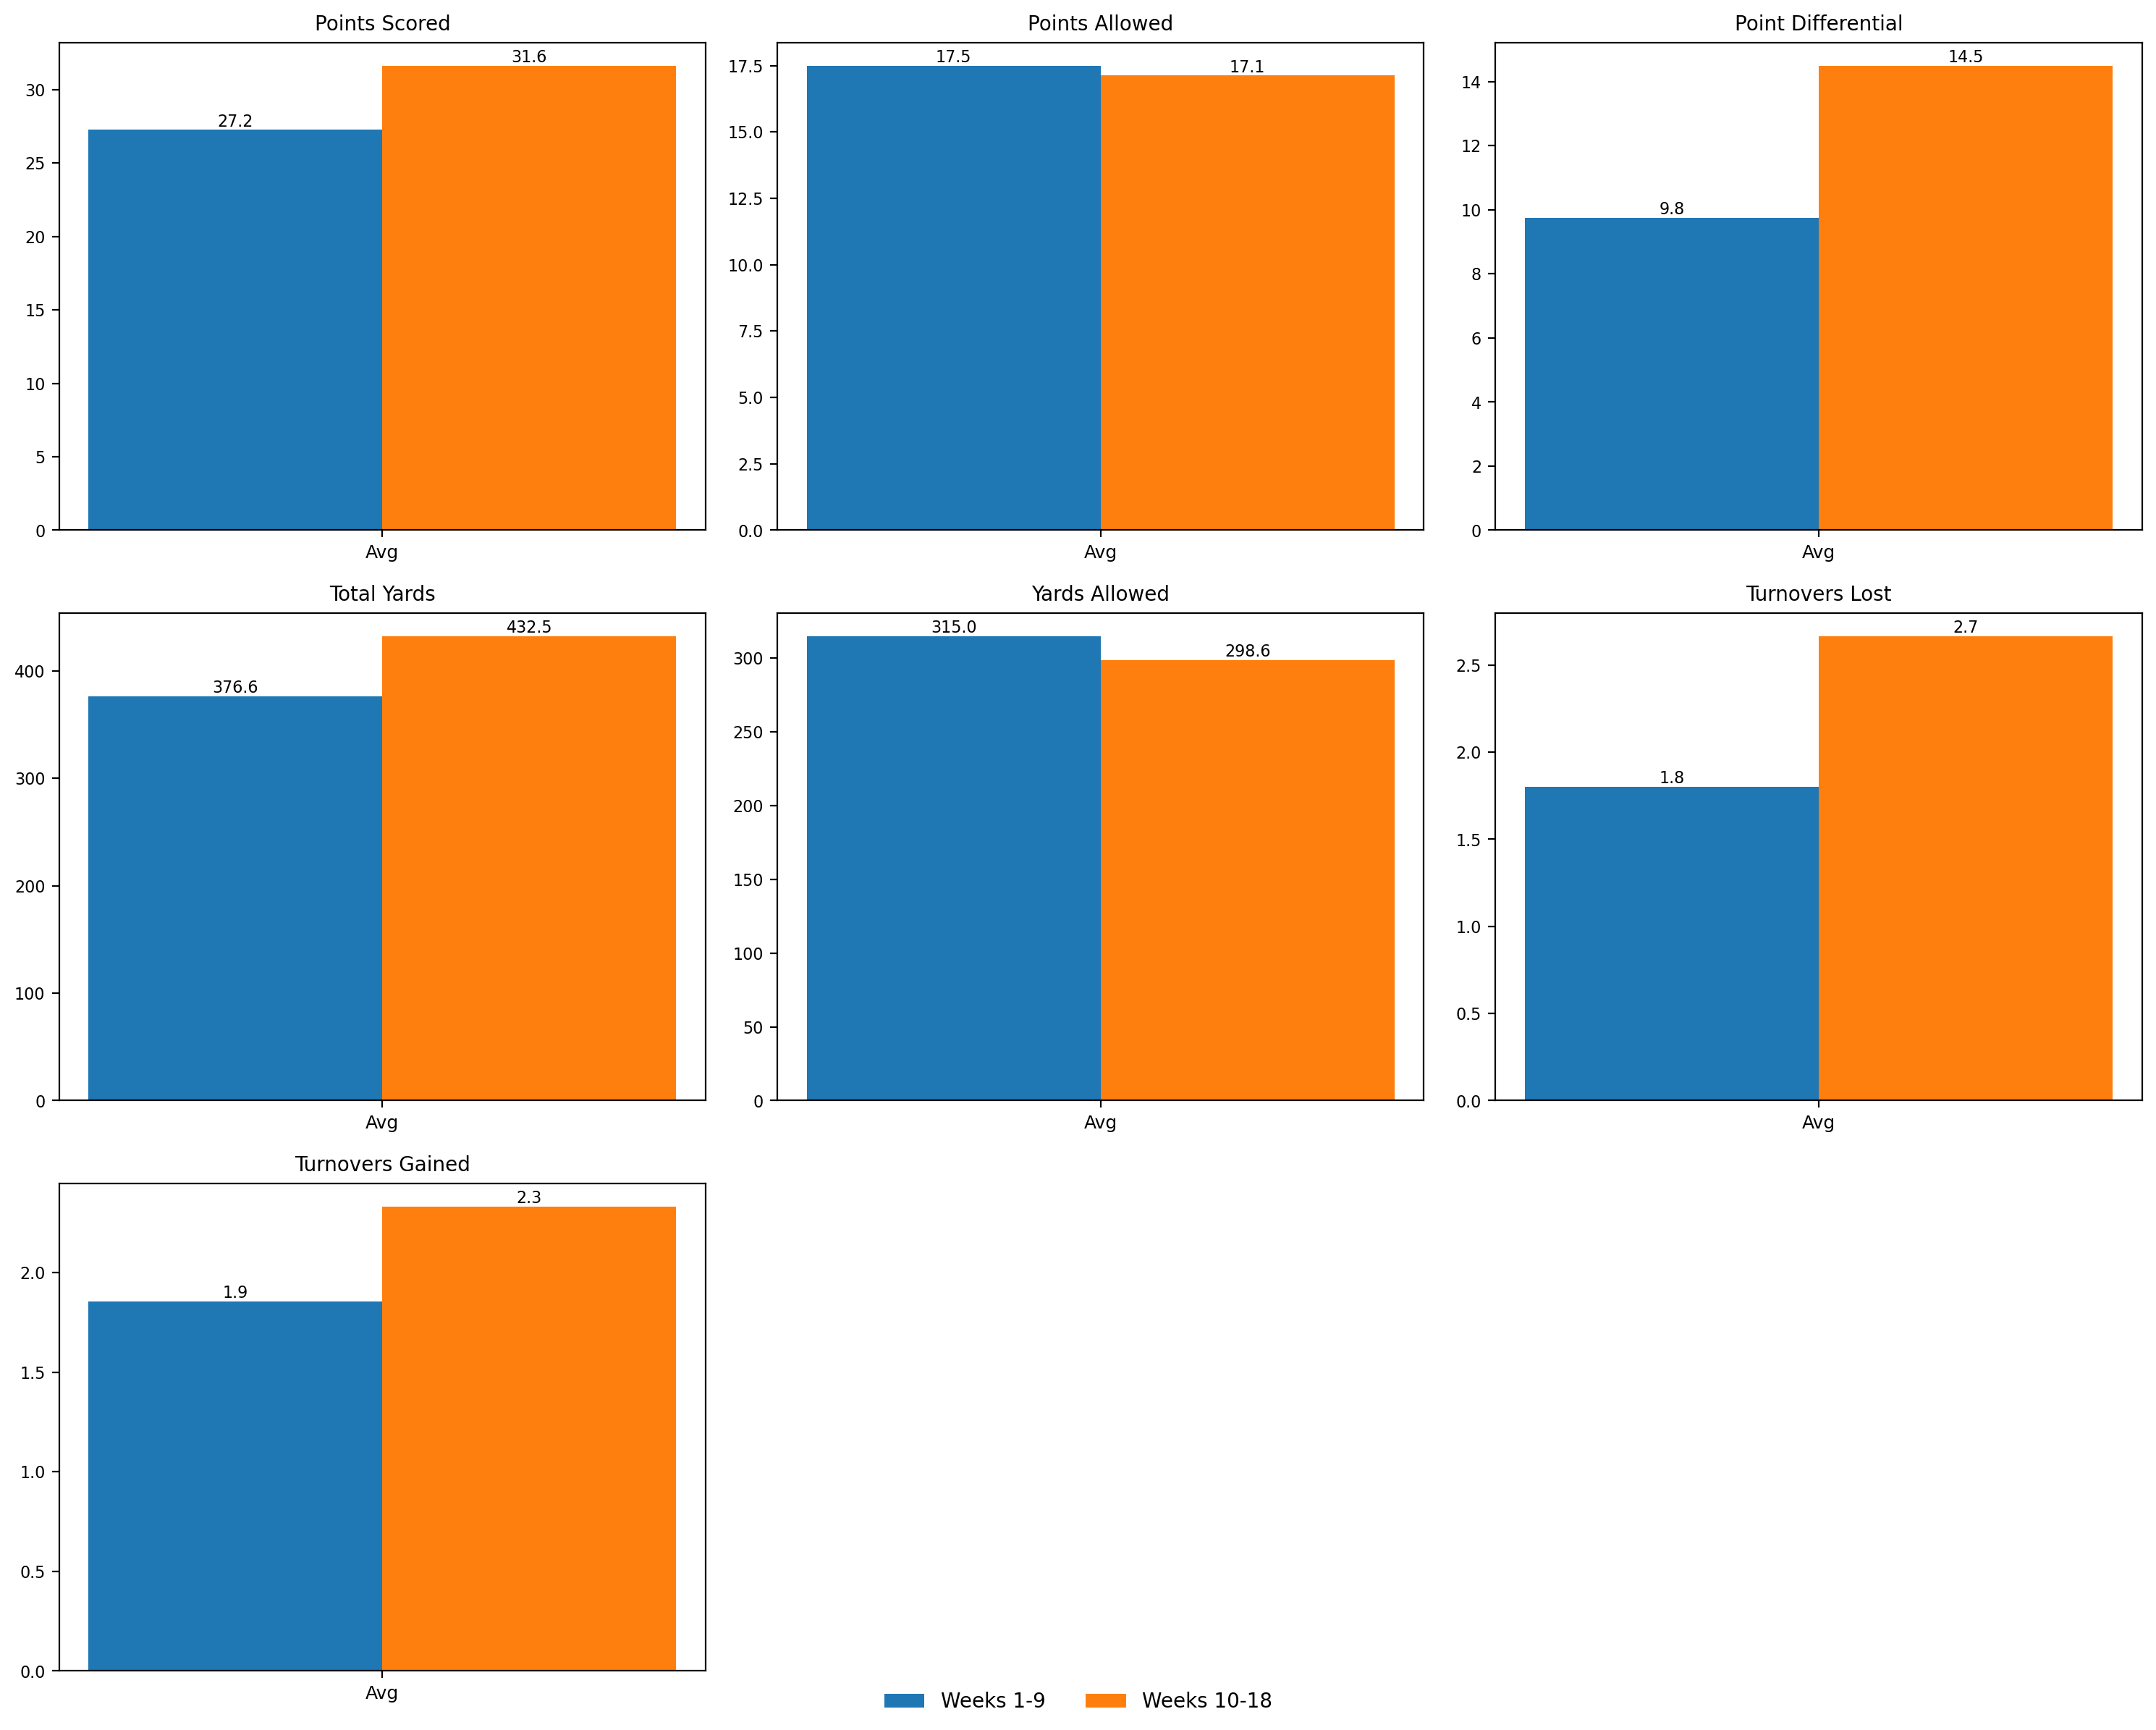

In [38]:
label_map = {
    "points_scored_avg": "Points Scored",
    "points_allowed_avg": "Points Allowed",
    "point_differential_avg": "Point Differential",
    "total_yards_avg": "Total Yards",
    "yards_allowed_avg": "Yards Allowed",
    "turnovers_lost_avg": "Turnovers Lost",
    "turnovers_gained_avg": "Turnovers Gained"
}

metrics = season_23_halves['metric'].tolist()
first = season_23_halves['weeks_1-9'].to_numpy(dtype=float)
second = season_23_halves['weeks_10-18'].to_numpy(dtype=float)

n = len(metrics)
cols = 3                                 # tweak to 2/3/4 based on how many metrics you have
rows = math.ceil(n / cols)
bar_w = 0.4

fig, axes = plt.subplots(rows, cols, figsize=(cols*5.0, rows*4.2))
axes = np.array(axes).reshape(-1)        # flatten in case rows*cols > 1

for i, ax in enumerate(axes):
    if i >= n:
        ax.axis('off')
        continue

    x = np.array([0, 1])
    ax.bar(x - bar_w/2, [first[i], np.nan], width=bar_w, label='Weeks 1-9')   # placeholder to keep legend order
    ax.clear()  # reset, then plot both properly

    ax.bar(0 - bar_w/2, first[i], width=bar_w, label='Weeks 1-9')
    ax.bar(0 + bar_w/2, second[i], width=bar_w, label='Weeks 10-18')

    # Cosmetic tweaks
    ax.set_title(label_map.get(metrics[i], metrics[i]), fontsize=10)
    ax.set_xticks([0])
    ax.set_xticklabels(['Avg'], fontsize=9)
    ax.tick_params(axis='y', labelsize=8)

    # Value labels
    for x_pos, val in [(0 - bar_w/2, first[i]), (0 + bar_w/2, second[i])]:
        ax.text(x_pos, val, f"{val:.1f}", ha='center', va='bottom', fontsize=8)

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False)

#plt.suptitle('49ers 2023 — First vs Second Half (per Metric)', y=0.99, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [31]:
print(season_23_halves)

                   metric   weeks_1-9  weeks_10-18
0       points_scored_avg   27.250000    31.625000
1      points_allowed_avg   17.500000    17.125000
2  point_differential_avg    9.750000    14.500000
3         total_yards_avg  376.625000   432.500000
4       yards_allowed_avg  315.000000   298.625000
5      turnovers_lost_avg    1.800000     2.666667
6    turnovers_gained_avg    1.857143     2.333333


### Highest scoring match

In [32]:
print(season_23.loc[season_23['score_tm'].idxmax()])

Week                            15
Day                            Sun
Date                        Dec-17
year                          2023
sf_rec                        11.0
opp_rec                        3.0
Opp              Arizona Cardinals
score_tm                      45.0
score_opp                     29.0
offense_1stD                  24.0
offense_totYd                406.0
offense_passY                262.0
offense_rushY                144.0
offense_to                     NaN
defense_1stD                  22.0
defense_totYd                436.0
defence_passY                202.0
defense_rushY                234.0
defense_to                     2.0
ep_offense                   26.28
ep_defense                   -5.83
ep_sp_Tms                    -1.07
win_lose                         1
home_away                        0
point_diff                    16.0
turnover_diff                  NaN
Name: 14, dtype: object


### Lowest scoring match

In [33]:
print(season_23.loc[season_23['score_tm'].idxmin()])

Week                            6
Day                           Sun
Date                       Oct-15
year                         2023
sf_rec                        5.0
opp_rec                       1.0
Opp              Cleveland Browns
score_tm                     17.0
score_opp                    19.0
offense_1stD                 15.0
offense_totYd               215.0
offense_passY               107.0
offense_rushY               108.0
offense_to                    1.0
defense_1stD                 18.0
defense_totYd               334.0
defence_passY               174.0
defense_rushY               160.0
defense_to                    2.0
ep_offense                  -6.05
ep_defense                  11.32
ep_sp_Tms                   -7.34
win_lose                        0
home_away                       0
point_diff                   -2.0
turnover_diff                 1.0
Name: 5, dtype: object


### Summary
In 2023, the 49ers' offence improved in the second half of the season. They averaged 31.63 points per game in weeks 10-18 vs. 27.25 in weeks 1-8, while the defence allowed slightly fewer points (17.13 vs 17.50). As a result, the average point differential widened from +9.75 to +14.50. Under the hood, total offence rose (432.5 vs 376.6 yards per game) and yards allowed fell (298.6 vs 315.50), although turnovers lost increased (2.67 vs 1.80) alongside a bump in takeaways (2.33 vs 1.86).

The highest scoring game was week 15 at Arizona (away), a 45-29 win with 406 total yards, 24 first downs, and two defensive takeaways; with the opponent having had 3 wins at this point. 
The lowest scoring game was week 6 at Cleveland (away), a 17-19 loss with just 215 total yards, 15 first downs, and one giveaway; the opponent had 1 win at that time.

Together, this indicates that opponent quality, with yardage and turnovers, help explain the scoring extremes, while the second-half offence was notable more productive and the defence remained consistently strong. 

## 4. Save files

In [50]:
season_14.to_csv("../data/clean_2014_season.csv", index=False)
season_15.to_csv("../data/clean_2015_season.csv", index=False)
season_16.to_csv("../data/clean_2016_season.csv", index=False)
season_17.to_csv("../data/clean_2017_season.csv", index=False)
season_18.to_csv("../data/clean_2018_season.csv", index=False)
season_19.to_csv("../data/clean_2019_season.csv", index=False)
season_20.to_csv("../data/clean_2020_season.csv", index=False)
season_21.to_csv("../data/clean_2021_season.csv", index=False)
season_22.to_csv("../data/clean_2022_season.csv", index=False)
season_23.to_csv("../data/clean_2023_season.csv", index=False)
season_24.to_csv("../data/clean_2024_season.csv", index=False)
